In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_asr.configs.config import SpeechConfig
from tensorflow_asr.featurizers import speech_featurizers
from tensorflow_asr.utils import env_util

env_util.setup_environment()

speech_conf = SpeechConfig({
    "sample_rate": 16000,
    "frame_ms": 25,
    "stride_ms": 10,
    "feature_type": "log_mel_spectrogram",
    "preemphasis": 0.97,
    "normalize_signal": False,
    "normalize_feature": True,
    "normalize_per_frame": True, # Must use this option for chunks if normalize_feature is enable
    "num_feature_bins": 80,
    "center": False,
    "top_db": None,
})
signal = speech_featurizers.read_raw_audio("./test.flac", speech_conf.sample_rate)

signal length: 143040
(80, 891)


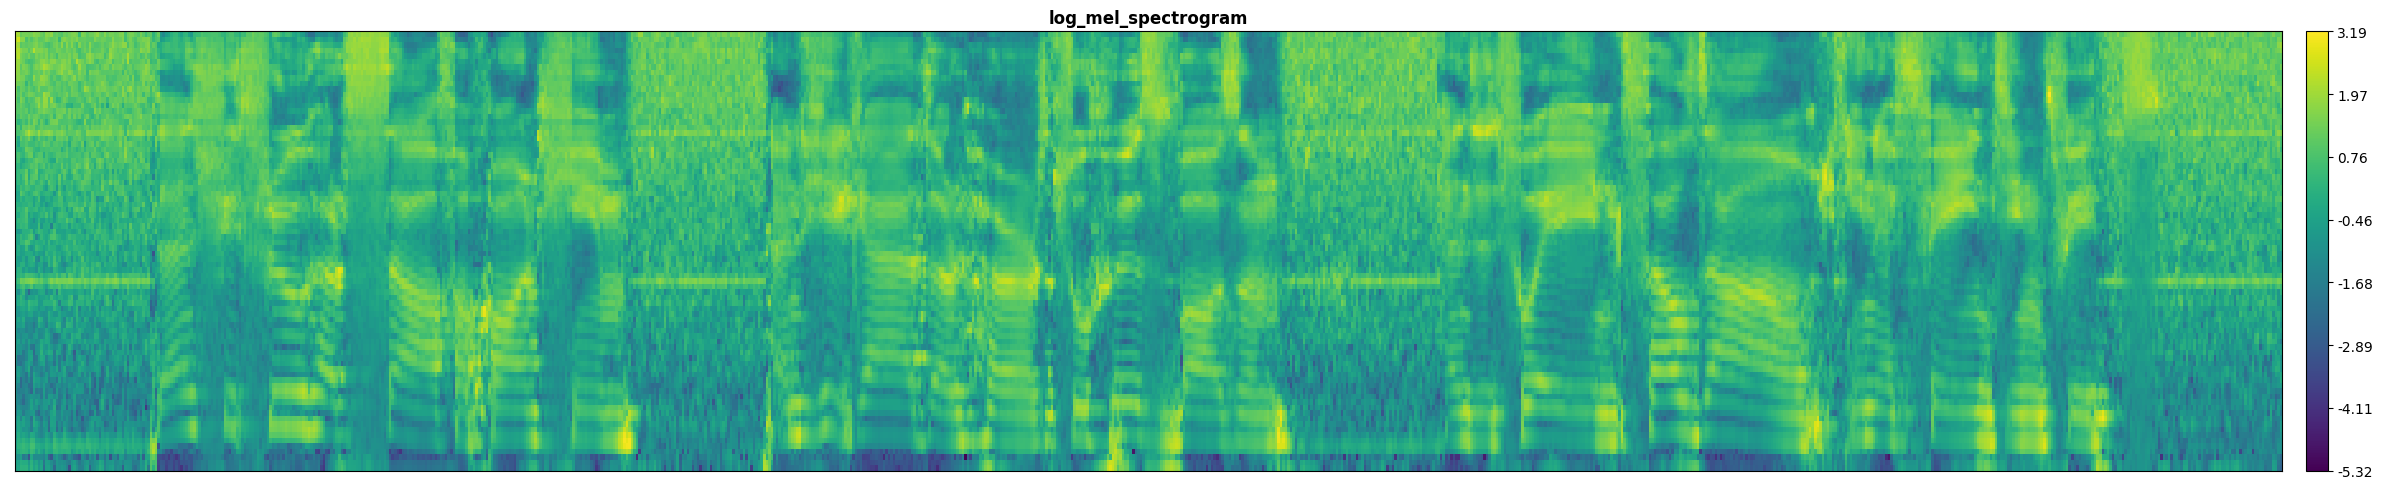

1.0
[-1.3609607  -1.334505   -1.6902323  -0.78325784 -0.22573768 -0.06744123
 -0.12386002 -0.36869118 -0.42262277 -0.29739785 -0.18513407 -0.17369924
 -0.33582574 -0.41216305 -0.3838201  -0.36805478 -0.42592353 -0.45388514
 -0.36270347 -0.47443357 -0.50398034 -0.35042894 -0.44127652 -0.32767886
 -0.39314783 -0.33258852 -0.30469802 -0.14662659 -0.16615385 -0.20221147
 -0.07307311 -0.05207502 -0.06838139  0.2089716   0.44185492  0.20854673
 -0.06232436 -0.22029014 -0.23177646 -0.31251624 -0.33371335 -0.28741825
 -0.26269236 -0.14595383 -0.01376063  0.15248272  0.3518191   0.4904311
  0.5683235   0.5734917   0.4966088   0.3568198   0.30366522  0.35720068
  0.30485493  0.26119918  0.41444013  0.62708116  0.66779786  0.5554061
  0.6097767   0.8504617   0.62443334  0.39873004  0.48144025  0.4963378
  0.3760955   0.16893983  0.04674688  0.1216681   0.19272898  0.32659048
  0.52329654  0.5297198   0.5213663   0.54885     0.5166297   0.3917154
  0.25291505  0.16367577]
With chunk size: 512 and 

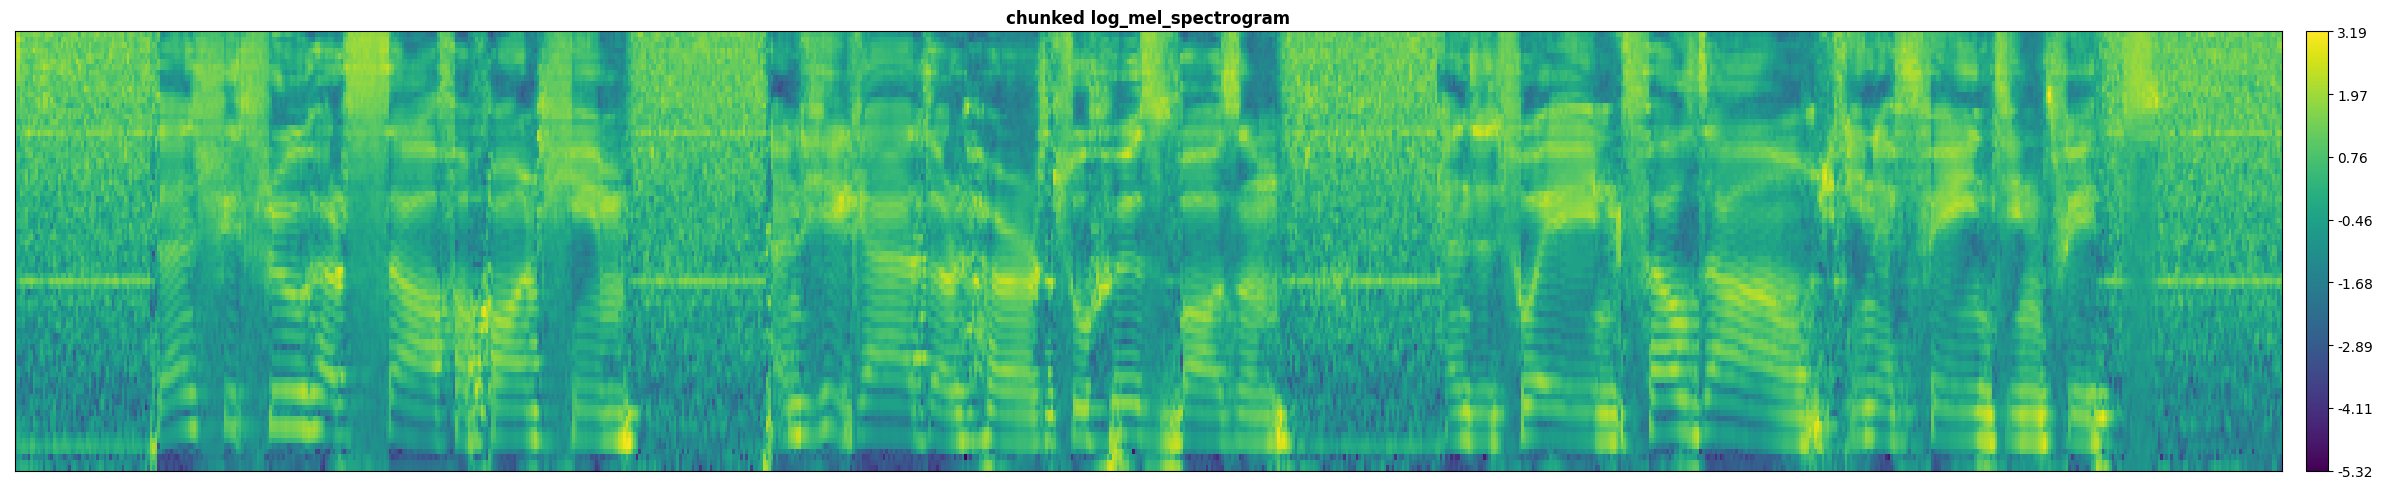

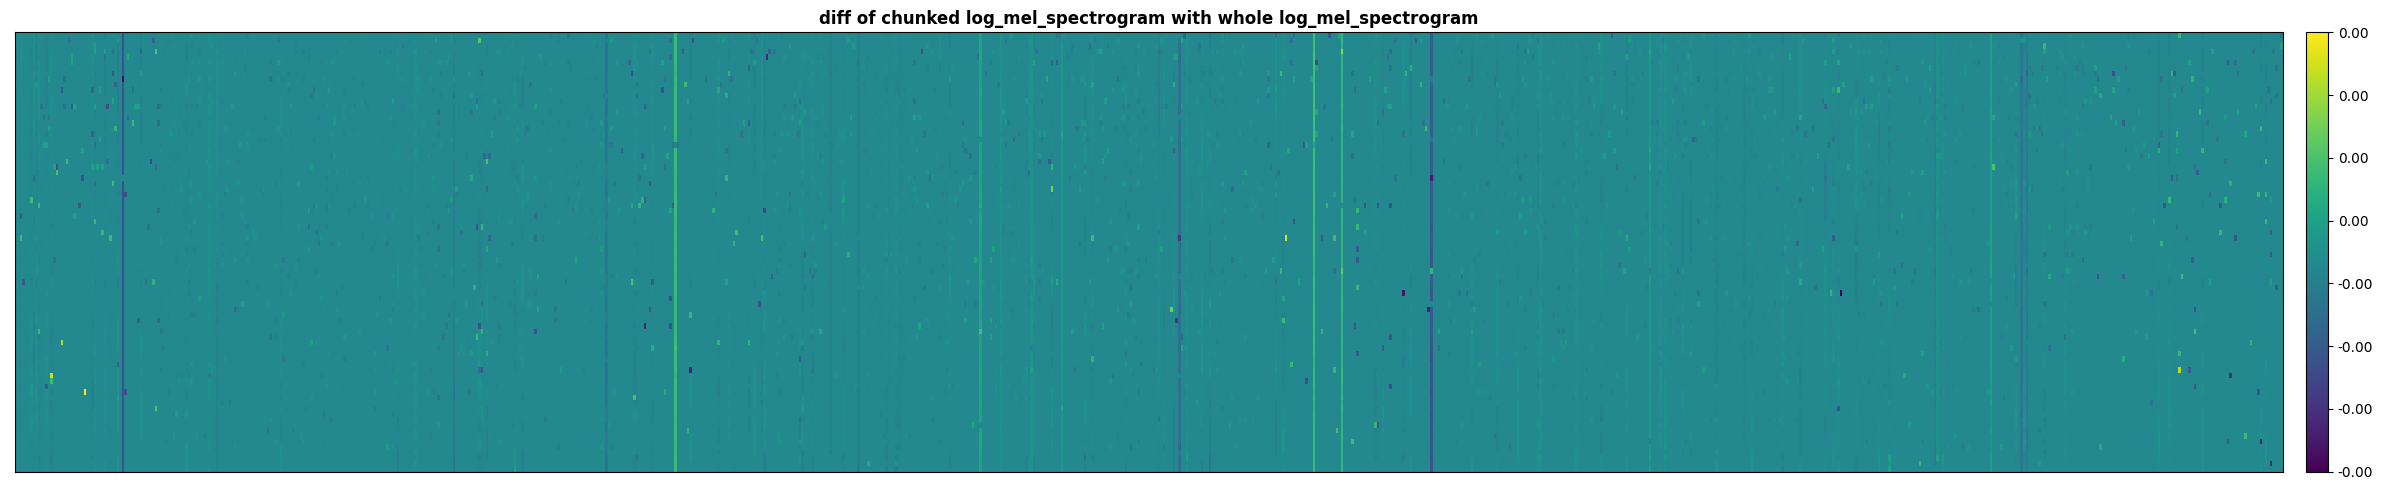

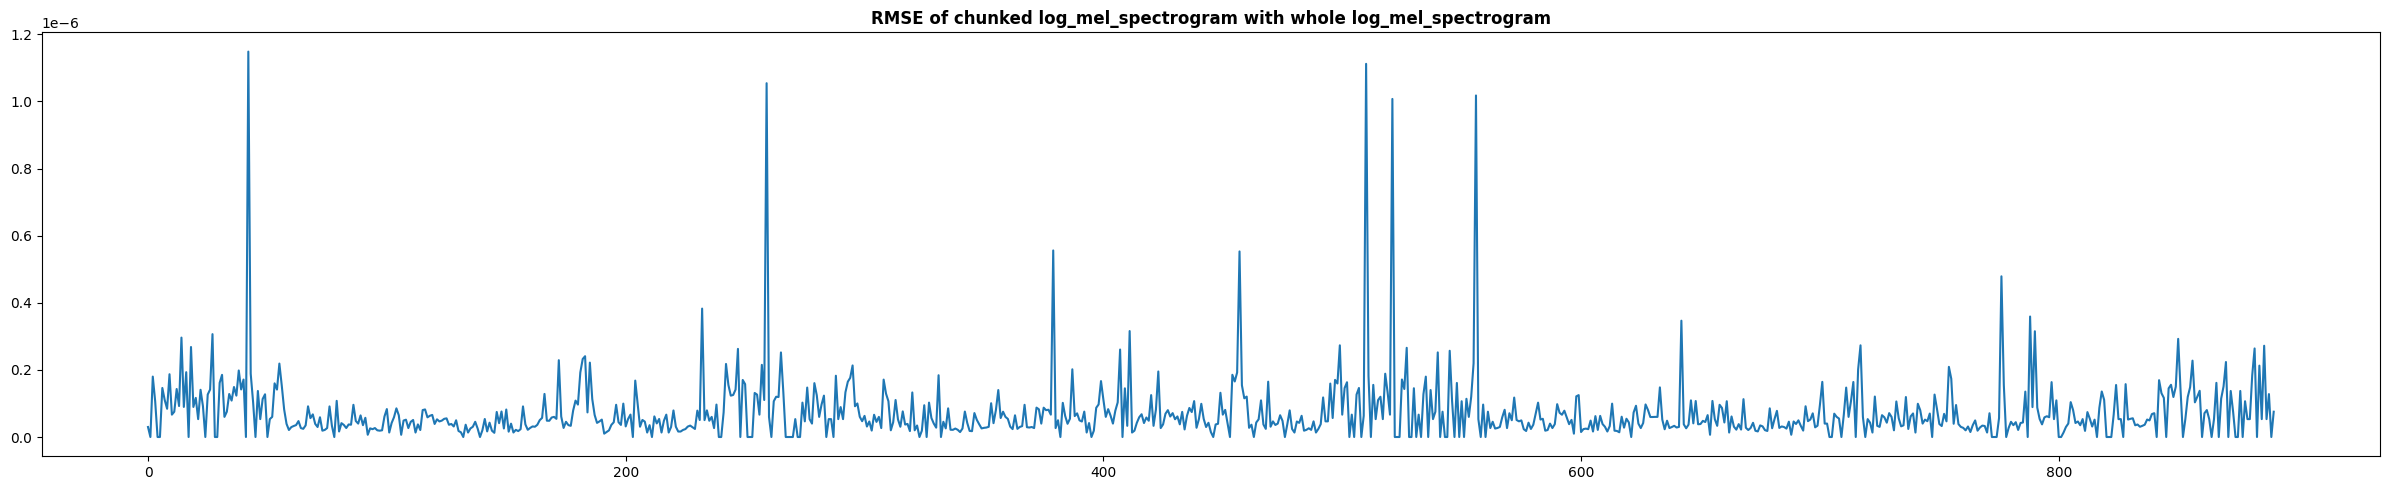

In [15]:
print(f"signal length: {len(signal)}")
sf = speech_featurizers.TFSpeechFeaturizer(speech_conf)
ft = sf.extract(signal)
ft = tf.squeeze(ft, axis=-1)
ft = ft.numpy().T
print(ft.shape)

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title("log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(ft, cmap="viridis")
v1 = np.linspace(ft.min(), ft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

print(np.std(ft))
print(np.mean(ft, axis=1))

stride = sf.speech_config.frame_step
chunk_size = sf.nfft + stride - sf.speech_config.frame_step
print(f"With chunk size: {chunk_size} and nfft: {sf.nfft}")
signal_length = len(signal)
all_ft = None
for i in range(int(np.ceil((signal_length - chunk_size) / stride))): # this ensure the fft shape of chunked signal is the same with whole signal
    chunk = signal[i * stride: i*stride + chunk_size]
    # cft = sf.power_to_db(sf.stft(chunk))
    cft = sf.extract(chunk)
    cft = tf.squeeze(cft, axis=-1)
    cft = cft.numpy()
    if all_ft is None:
        all_ft = cft
    else:
        all_ft = np.concatenate([all_ft, cft], axis=0)
all_ft = all_ft.T
print(all_ft.shape)

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"chunked log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(all_ft, cmap="viridis")
v1 = np.linspace(all_ft.min(), all_ft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

dft = all_ft - ft

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"diff of chunked log_mel_spectrogram with whole log_mel_spectrogram", fontweight="bold")
librosa.display.specshow(dft, cmap="viridis")
v1 = np.linspace(dft.min(), dft.max(), 8, endpoint=True)
plt.colorbar(pad=0.01, fraction=0.02, ax=ax, format="%.2f", ticks=v1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(24, 5))
ax = plt.gca()
ax.set_title(f"RMSE of chunked log_mel_spectrogram with whole log_mel_spectrogram", fontweight="bold")
plt.plot(np.sqrt(np.mean(dft ** 2, axis=0)))
plt.tight_layout()
plt.show()